### Check *analytical* pipeline using datasets/parameters of interest by comparing results with reference outputs at the district level

In [1]:
import os
if os.getcwd().split("\\")[-1] != "anticipatory-action":
    os.chdir("..")
print(os.getcwd())

c:\Users\amine.barkaoui\OneDrive - World Food Programme\Documents\GitHub\anticipatory-action


In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
from AA.src.params import Params
from AA.triggers import read_aggregated_probs
from hip.analysis.analyses.drought import get_accumulation_periods

Prepare parameters

In [4]:
params = Params(iso='TEST', index='SPI', output_path='.')

INFO:root:Loaded config from file (YAML): ./config/test_config.yaml


Read data (b-c probabilities, roc scores)

In [11]:
probs_ref = read_aggregated_probs(
    f"{params.output_path}/data/{params.iso}/zarr/{params.calibration_year}",
    params,
).bc.sortby("category")
display(probs_ref)

data_of_interest = "xsdba" # change with output name of dataset of interest

probs_ds = read_aggregated_probs(
    f"{params.output_path}/data/{params.iso}/{data_of_interest}/zarr/{params.calibration_year}",
    params,
).bc.sortby("category")
display(probs_ds)

<xarray.DataArray 'bc' (issue: 2, index: 5, time: 41, category: 3, district: 9)> Size: 89kB
dask.array<getitem, shape=(2, 5, 41, 3, 9), dtype=float64, chunksize=(1, 1, 41, 3, 9), chunktype=numpy.ndarray>
Coordinates:
  * issue     (issue) int64 16B 6 7
  * index     (index) <U7 140B 'spi DJ' 'spi ND' 'spi NDJ' 'spi ON' 'spi OND'
  * time      (time) int64 328B 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021
  * category  (category) <U8 96B 'Mild' 'Moderate' 'Severe'
  * district  (district) <U10 360B 'Caia' 'Chemba' ... 'Morrumbala' 'Mutarara'

<xarray.DataArray 'bc' (issue: 2, index: 5, time: 41, category: 3, district: 9)> Size: 89kB
dask.array<getitem, shape=(2, 5, 41, 3, 9), dtype=float64, chunksize=(1, 1, 41, 3, 9), chunktype=numpy.ndarray>
Coordinates:
  * issue     (issue) int64 16B 6 7
  * index     (index) <U7 140B 'spi DJ' 'spi ND' 'spi NDJ' 'spi ON' 'spi OND'
  * time      (time) int64 328B 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021
  * category  (category) <U8 96B 'Mild' 'Moderate' 'Severe'
  * district  (district) <U10 360B 'Caia' 'Chemba' ... 'Morrumbala' 'Mutarara'

In [ ]:
fbfref = pd.read_csv(f'{params.output_path}/data/test/auc/fbf.districts.roc.spi.2022.csv')
fbfref = fbfref.rename(columns={'AUC_best': 'AUC_ref', 'BC':'BC_ref'})
display(fbfref)

data_of_interest = "xsdba" # change with output name of dataset of interest

fbf = pd.read_csv(f'{params.output_path}/data/test/{data_of_interest}/auc/fbf.districts.roc.spi.2022.csv')
display(fbf)

,category,district,AUC_ref,BC_ref,Index,issue
0,Severe,Caia,0.661612,1,SPI ON,6
1,Severe,Chemba,0.613227,1,SPI ON,6
2,Severe,Cheringoma,0.607081,1,SPI ON,6
3,Severe,Gorongosa,0.645238,1,SPI ON,6
4,Severe,Maringue,0.610639,0,SPI ON,6
...,...,...,...,...,...,...
211,Mild,Maringue,0.783496,0,SPI NDJ,7
212,Mild,Marromeu,0.737041,0,SPI NDJ,7
213,Mild,Mutarara,0.729885,0,SPI NDJ,7
214,Mild,Mopeia,0.698615,0,SPI NDJ,7


,category,district,AUC_best,BC,Index,issue
0,Mild,Caia,0.651562,0,SPI ON,6
1,Mild,Chemba,0.576463,0,SPI ON,6
2,Mild,Cheringoma,0.716907,0,SPI ON,6
3,Mild,Gorongosa,0.625661,0,SPI ON,6
4,Mild,Maringue,0.686906,0,SPI ON,6
...,...,...,...,...,...,...
211,Severe,Maringue,0.780303,0,SPI NDJ,7
212,Severe,Marromeu,0.790088,0,SPI NDJ,7
213,Severe,Mutarara,0.786458,0,SPI NDJ,7
214,Severe,Mopeia,0.776833,0,SPI NDJ,7


### Comparison of aggregated probabilities

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


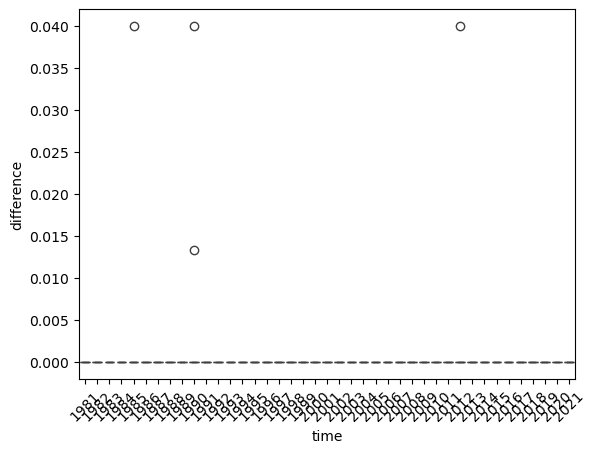

In [32]:
diff = abs(probs_ref - probs_ds)
# Convert to dataframe for easier plotting
df = diff.to_dataframe(name='difference').reset_index()


# Or boxplot by one dimension (e.g., by time if you have it)
sns.boxplot(x='time', y='difference', data=df)
plt.xticks(rotation=45)
plt.show()

### Comparison of ROC scores at the district level

In [6]:
def plot_hist(comparison, title, xlabel, xmin, xmax, s=1, mask_text=False):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (6,4))

    quant_5, quant_25, quant_50, quant_75, quant_95 = comparison.difference.quantile(0.05), comparison.difference.quantile(0.25), comparison.difference.quantile(0.5), comparison.difference.quantile(0.75), comparison.difference.quantile(0.95)

    # [quantile, opacity, length]
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    comparison.difference.plot(kind='hist', density = True, alpha = 0.65, bins=200)
    comparison.difference.plot(kind='kde')

    # Plot the lines with a loop
    import matplotlib.pyplot as plt
    for i in quants: plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax) 

    # Y
    ax.set_yticklabels([])
    ax.set_ylabel("")

    if not(mask_text):
        plt.text(quant_5-.01, 0.15 * s, "5th", size = 10, alpha = 0.8)
        plt.text(quant_25-.013, 0.27 * s, "25th", size = 11, alpha = 0.85)
        plt.text(quant_50-.013, 0.33 * s, "50th", size = 12, alpha = 1)
        plt.text(quant_75-.013, 0.39 * s, "75th", size = 11, alpha = 0.85)
        plt.text(quant_95-.025, 0.47 * s, "95th Percentile", size = 10, alpha =.8)

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

Ratio of bias-corrected values in the final output

In [ ]:
# Ratio of cases using Bias Correction
fbf.BC.sum() / len(fbf)

0.06481481481481481

In [17]:
fbfref.BC_ref.sum() / len(fbfref)

0.06481481481481481

Histogram of difference between full outputs (auc_to_compare - python_reference)

In [18]:
comparison = fbf.set_index(['district', 'category', 'Index', 'issue']).join(fbfref.set_index(['district', 'category', 'Index', 'issue'])).reset_index()

In [19]:
comparison['difference'] = comparison.AUC_best - comparison.AUC_ref

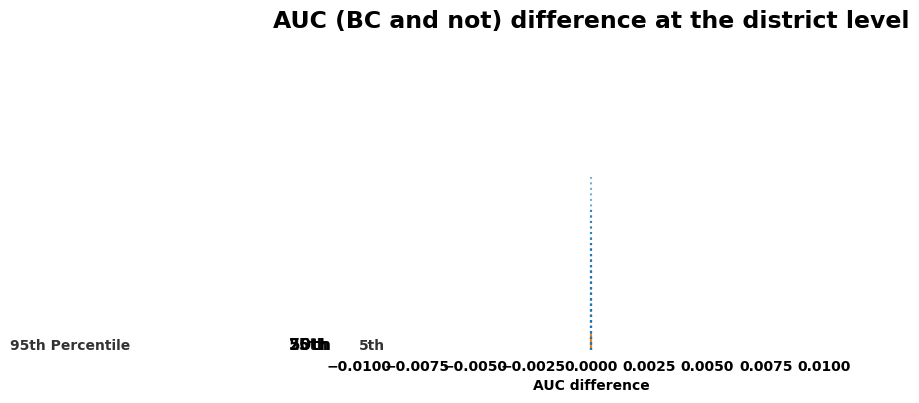

In [22]:
plot_hist(comparison, title="AUC (BC and not) difference at the district level", xlabel="AUC difference", xmin=-.01, xmax=.01, s=10)

### Difference (auc_to_compare - python_reference) on the full output by category / district / index / issue

Text(0.5, 0.98, 'SEVERE CATEGORY')

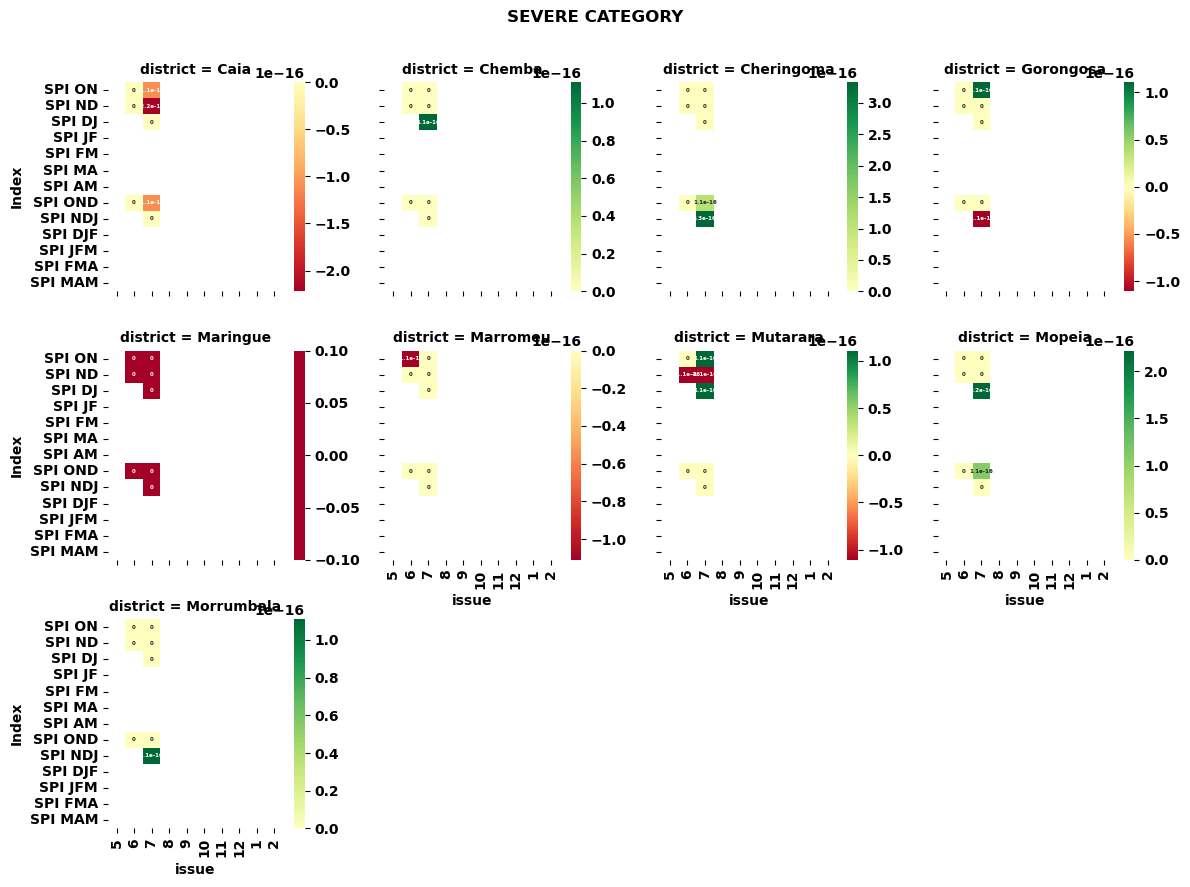

In [24]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(comparison.loc[(comparison.category=='Severe')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('SEVERE CATEGORY')

Text(0.5, 0.98, 'MODERATE CATEGORY')

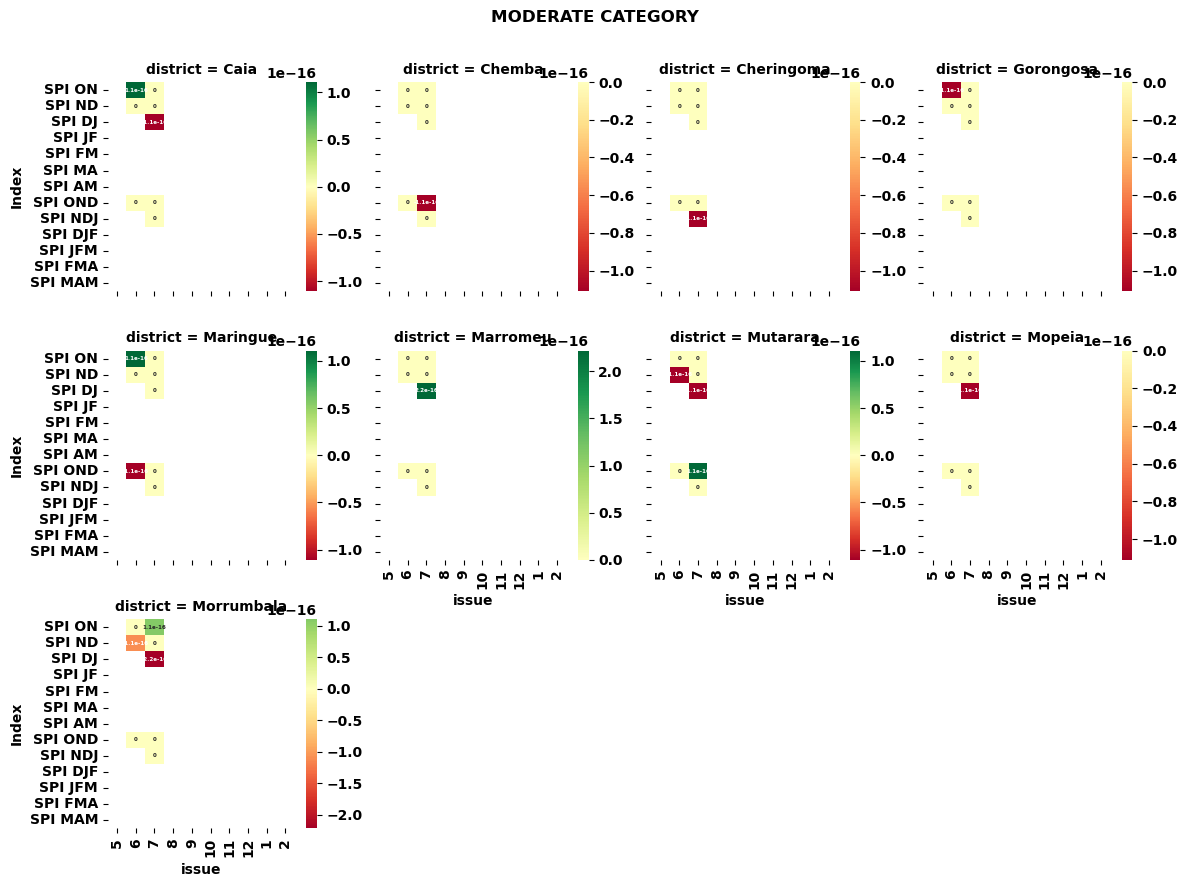

In [25]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Moderate')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MODERATE CATEGORY')

Text(0.5, 0.98, 'MILD CATEGORY')

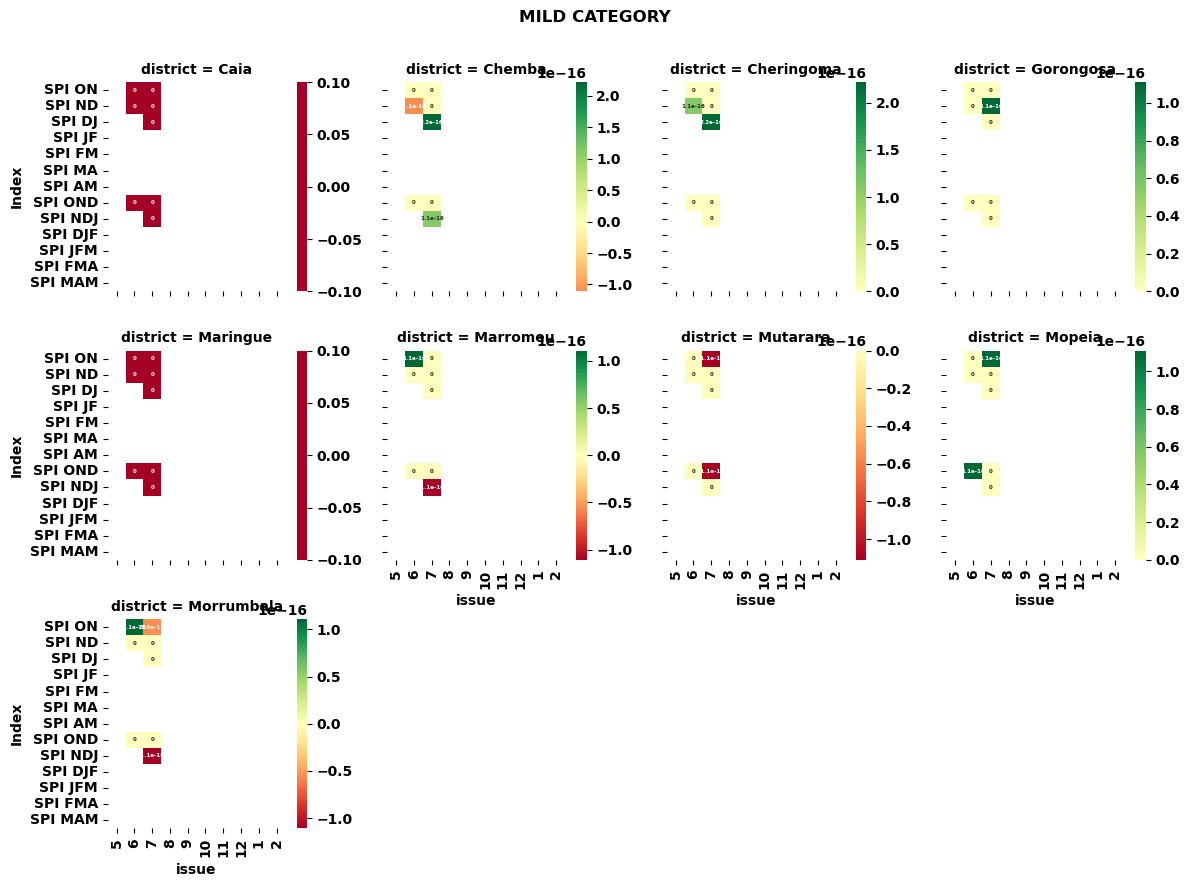

In [26]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Mild')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MILD CATEGORY')

### Visualisation of AUC differences for each pair of variables to highlight any systematic difference

**Average difference**

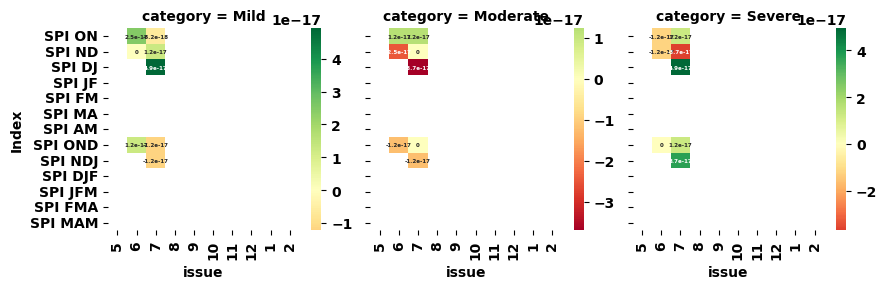

In [27]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'Index', 'category']).mean('district').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

In [ ]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'district', 'category']).mean('Index').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

In [ ]:
x_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="Index", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['Index', 'district', 'category']).mean('issue').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)